In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import statsmodels.api as sm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neural_network import MLPClassifier
import joblib

In [2]:
df = pd.read_csv("Credit Card Default II (balance).csv")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.shape

(3428, 4)

In [5]:
df.head()

,income,age,loan,default
0,66155.92510,59.017015,8106.532131,0
1,34415.15397,48.117153,6564.745018,0
2,57317.17006,63.108049,8020.953296,0
3,42709.53420,45.751972,6103.642260,0
4,66952.68885,18.584336,8770.099235,1


# Data Cleaning and Exploration

In [6]:
df.describe()
# Default is treated as numeric, strictly speaking it should be categorical
# Age has negative values and decimal values

,income,age,loan,default
count,3428.000000,3428.000000,3428.000000,3428.000000
mean,45136.875975,34.795950,5591.986695,0.500000
std,14425.486619,12.840055,3174.522430,0.500073
min,20014.489470,-52.423280,1.377630,0.000000
25%,32827.211177,25.171939,3103.357467,0.000000
50%,45546.632873,30.086842,5540.305046,0.500000
75%,57514.794130,44.369461,7809.377943,1.000000
max,69995.685580,63.971796,13766.051240,1.000000


In [7]:
df.dtypes
# Age is treated as a float and not int, which is strange
# As mentioned, default is treated as numeric (int) instead of categorical

income     float64
age        float64
loan       float64
default      int64
dtype: object

In [8]:
df.default = df.default.astype("category")

In [9]:
df.isna().sum() # No NA values

income     0
age        0
loan       0
default    0
dtype: int64

In [10]:
df.duplicated().sum() # No duplicate rows

0

Income

<AxesSubplot:xlabel='income'>

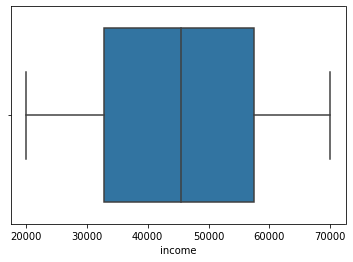

In [11]:
sns.boxplot(data=df, x="income")
# No outliers, median about 45000

<AxesSubplot:xlabel='income', ylabel='Count'>

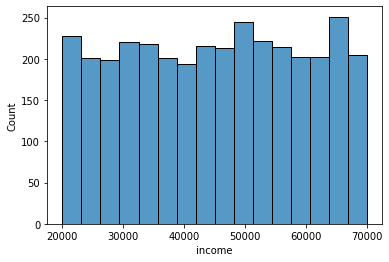

In [12]:
sns.histplot(data=df, x="income")

Age

<AxesSubplot:xlabel='age', ylabel='Count'>

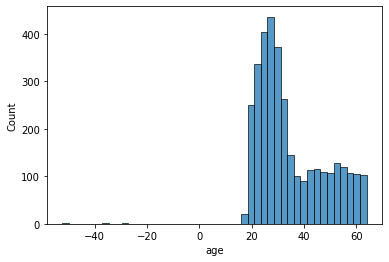

In [13]:
sns.histplot(data=df, x="age")
# Most people are around 30 years old

<AxesSubplot:xlabel='age'>

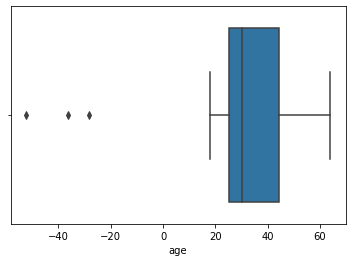

In [14]:
sns.boxplot(data=df, x="age")
# 3 negative values and outliers, median age about 30

In [15]:
df[df.age < 0]
# Only 3 rows out of 3000, can remove

,income,age,loan,default
15,50501.72669,-28.218361,3977.287432,0
21,32197.62070,-52.423280,4244.057136,0
26,63287.03891,-36.496976,9595.286289,0


In [16]:
df = df[df.age > 0]
# Drop the 3 rows

Loan

<AxesSubplot:xlabel='loan'>

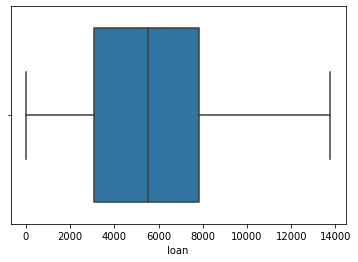

In [17]:
sns.boxplot(data=df, x="loan")
# No outliers, median close to 6000

<AxesSubplot:xlabel='loan', ylabel='Count'>

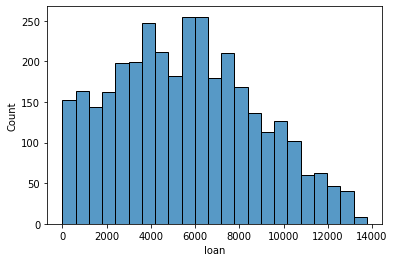

In [18]:
sns.histplot(data=df, x="loan")

Default

<AxesSubplot:xlabel='default', ylabel='count'>

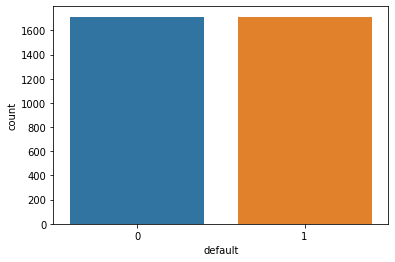

In [19]:
sns.countplot(data=df, x="default") # Balanced

In [20]:
df.default.value_counts() # Precisely balanced

1    1714
0    1711
Name: default, dtype: int64

### Other Exploration and Visualisation 

<AxesSubplot:xlabel='age', ylabel='Density'>

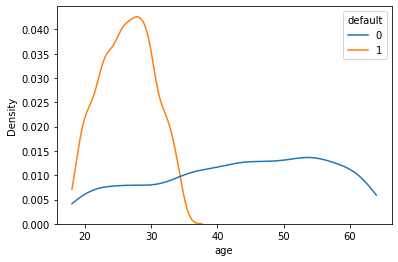

In [21]:
sns.kdeplot(data=df,x="age", hue="default", clip=(min(df.age),max(df.age)))
# People who default are generally younger at around 25-30

<AxesSubplot:xlabel='income', ylabel='Density'>

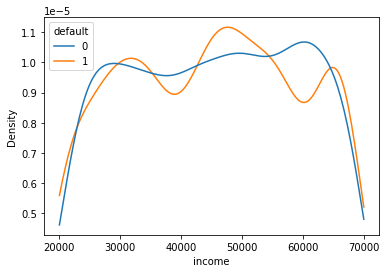

In [22]:
sns.kdeplot(data=df,x="income", hue="default", clip=(min(df.income),max(df.income)))
# Generally, for non-defaulters, the distribution is fairly even with no peak that really stands out
# For defaulters, there are 3 distinct peaks at around >30k, <50k and 65k

<AxesSubplot:xlabel='loan', ylabel='Density'>

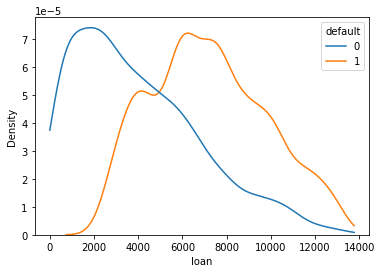

In [23]:
sns.kdeplot(data=df,x="loan", hue="default", clip=(min(df.loan),max(df.loan)))
# Defaulters generally have a higher loan amount

<AxesSubplot:>

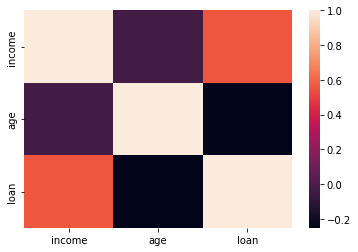

In [24]:
sns.heatmap(df.corr())
# Loan and income are moderately positively correlated

# Modelling: Preprocessing

Due to the large differences in the order of magnitude e.g. for age vs income, should perform scaling of X variables so that the model will not be biased towards X variables with larger magnitudes.

There are only 3 features, hence feature selection will not be performed

In [25]:
X = df.drop("default", axis=1)
Y = df.default

In [26]:
# Check collinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)
# Very high VIF for all, there is a potential issue of multicollinearity

  feature        VIF
0  income  12.181603
1     age   5.139917
2    loan   6.209883


In [27]:
# Scaling
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [28]:
# Normalisation
X_scaled = X.copy()

for i in X.columns:
    X_scaled[i]=stats.zscore(X[i].astype(float))

In [29]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(len(X.columns))]
print(vif_data)
# values are all around 1-1.5, no more issue of multicollinearity

  feature       VIF
0  income  1.475983
1     age  1.088217
2    loan  1.573994


In [30]:
# Set seed for reproducibility
seed=100

In [31]:
# Train-test split
X_train, X_test, Y_train, Y_test  = train_test_split(X_scaled,Y,test_size=0.3,stratify=Y,random_state=seed)

In [32]:
# Define a function for evaluating model for reusability
def evaluate(X, Y, model, data="Testset"):
    pred = model.predict(X)
    cm=confusion_matrix(Y, pred)
    ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_).plot()
    print(f"{data.capitalize()} Accuracy: ",accuracy_score(Y, pred))

# Logistic Regression

Assumptions:
1. There is a linear relationship between the independent variables and the log odds of the dependent variable
2. There is minimal or no mulitcollinearity among the independent variables
3. Each observation or row is independent
4. Binary logistic regression requires the dependent variable to be binary
5. The dataset is sufficiently large so that valid conclusions can be drawn from the model
6. There are no strongly influential outliers
7. For binary classifications, the probability threshold is 0.5

In [33]:
logreg = LogisticRegression(random_state=seed)
logreg.fit(X_train, Y_train)

LogisticRegression(random_state=100)

Trainset Accuracy:  0.9486858573216521


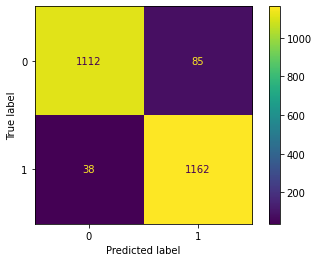

In [34]:
# Trainset accuracy and confusion matrix
evaluate(X_train, Y_train, logreg, "Trainset")

Testset Accuracy:  0.9552529182879378


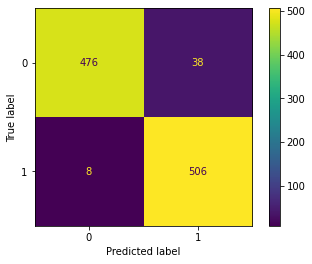

In [35]:
# Testset accuracy and confusion matrix
evaluate(X_test, Y_test, logreg, "Testset")

In [36]:
model=sm.Logit(Y,X)
result=model.fit()
print(result.summary2())
# Odds ratio confidence interval excludes 1 for all variables, so they are significant

Optimization terminated successfully.
         Current function value: 0.318884
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.540    
Dependent Variable: default          AIC:              2190.3562
Date:               2022-02-24 11:04 BIC:              2208.7727
No. Observations:   3425             Log-Likelihood:   -1092.2  
Df Model:           2                LL-Null:          -2374.0  
Df Residuals:       3422             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
income      -0.0001    0.0000  -11.2496  0.0000  -0.0001  -0.0001
age         -0.1018    0.0046  -22.1794  0.0000  -0.1108  -0.0928
loan    

In [37]:
importances = pd.DataFrame(data={
    'Variable': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances
# Variable importance according to logistic regression - according to this model, loan is the most important

,Variable,Importance
2,loan,5.198175
0,income,-3.291583
1,age,-4.432662


https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/#:~:text=Logistic%20regression%20does%20not%20really,with%20different%20solvers%20(solver).&text=Regularization%20(penalty)%20can%20sometimes%20be%20helpful

Logistic regression does not have any critical hyperparameters to tune. Logistic regression is also unlikely to overfit

# Decision Tree

Decision Trees do not need scaling or normalisation of independent variables. However, each row is assumed to be independent of one another

Independent variables that appear at higher nodes are generally more important than those on lower nodes. This depends on the node impurity which can be measured using Gini or entropy etc.

In [38]:
# Since scaling is not needed, do a train-test split on the non-scaled values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,stratify=Y,random_state=seed)

### Base model 

In [39]:
cart = tree.DecisionTreeClassifier(random_state=seed)
cart.fit(X_train,Y_train)

DecisionTreeClassifier(random_state=100)

Trainset Accuracy:  1.0


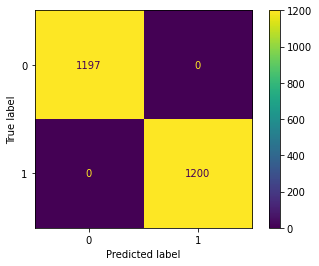

In [40]:
# Trainset
evaluate(X_train, Y_train, cart, "Trainset")

Testset Accuracy:  0.9883268482490273


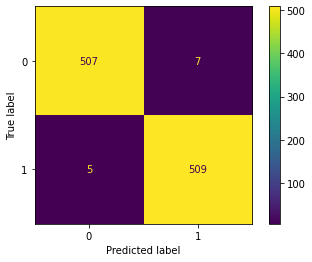

In [41]:
# Testset
evaluate(X_test, Y_test, cart, "Testset")
# Extremely high accuracy, even without any hyperparameter tuning.

In [42]:
# plt.figure(figsize=(25,20))
# _ = tree.plot_tree(cart, 
#                    feature_names=["income","age","loan"],
#                    class_names="default",
#                    filled=True)

### Hyperparameter tuning 

In [43]:
cart = tree.DecisionTreeClassifier(random_state=seed)

In [44]:
grid_params = [{"min_samples_split": [i for i in range(1,300)],
              "max_depth": [i for i in range(1,20)]}]

In [45]:
grid = GridSearchCV(cart, grid_params)
grid.fit(X_train, Y_train)
print(grid.best_params_)

{'max_depth': 8, 'min_samples_split': 4}


C:\Users\jacks\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
95 fits failed out of a total of 28405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jacks\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jacks\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\jacks\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a float in 

### Tuned Model 

In [46]:
cart = tree.DecisionTreeClassifier(min_samples_split = grid.best_params_["min_samples_split"],
                                  max_depth = grid.best_params_["max_depth"],
                                  random_state = seed)
cart.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=8, min_samples_split=4, random_state=100)

Testset Accuracy:  0.9863813229571985


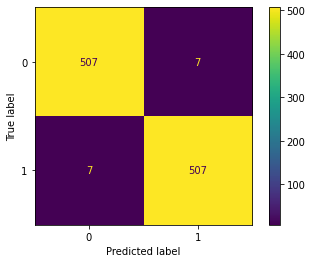

In [47]:
evaluate(X_test, Y_test, cart, "Testset")
# Accuracy drops very slightly after tuning, but are still very close

In [48]:
importances = pd.DataFrame(data={
    'Variable': X_train.columns,
    'Importance': cart.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances
# According to CART, age is the most important variable, then loan, then income

,Variable,Importance
1,age,0.579113
2,loan,0.292170
0,income,0.128717


Single decision trees tend to be unstable, so a small change in the data can lead to a large change in the optimal tree. Decision trees also tend to overfit, making it less generalisable

# Random Forest

Random forest addresses some of CART's issues through bagging to add randomness and stability. Like CART, it does not make assumptions about the underlying distribution (e.g. does not need to be normally distributed) and the only assumption it may make is that the sampling is representative.

Feature selection is generally not important for ensembles of decision trees: https://datascience.stackexchange.com/questions/51615/does-feature-selections-matter-to-decision-tree-algorithms

### Base model 

In [49]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=100)

Trainset Accuracy:  1.0


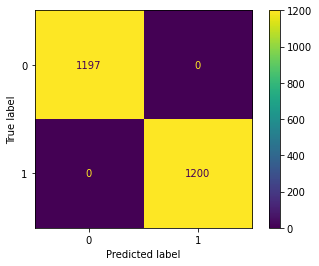

In [50]:
# Trainset
evaluate(X_train, Y_train, rf, "Trainset")

Testset Accuracy:  0.9922178988326849


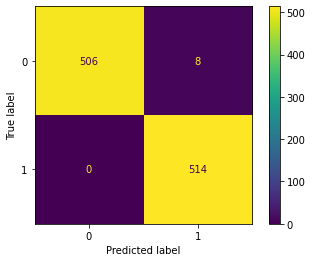

In [51]:
# Testset
evaluate(X_test, Y_test, rf, "Testset")

### Hyperparameter Tuning

In [52]:
rf = RandomForestClassifier(random_state=seed)

In [53]:
grid_params ={
            'max_depth':[5,10,20,30,40,50,60,70],
            'min_samples_split':[5,10,20,25,30,40,50]
            }

In [54]:
grid = GridSearchCV(rf, grid_params)
grid.fit(X_train, Y_train)
print(grid.best_params_)

{'max_depth': 20, 'min_samples_split': 5}


### Tuned Model 

In [55]:
rf = RandomForestClassifier(min_samples_split = grid.best_params_["min_samples_split"],
                                  max_depth = grid.best_params_["max_depth"],
                                  random_state = seed)
rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, min_samples_split=5, random_state=100)

Testset Accuracy:  0.9922178988326849


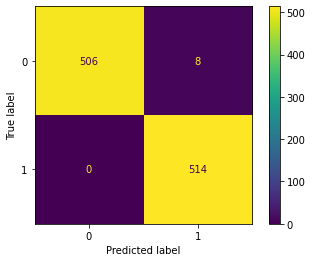

In [56]:
evaluate(X_test, Y_test, rf, "Testset")
# No change after tuning

In [57]:
importances = pd.DataFrame(data={
    'Variable': X_train.columns,
    'Importance': rf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances
# According to Random Forest, age is the most important variable, then loan, then income

,Variable,Importance
1,age,0.537146
2,loan,0.353572
0,income,0.109282


# XGBoost

XGBoost may assume that encoded integer values for each input variable have an ordinal relationship. Since this is also a decision tree model, each row is also treated as independent of one another.

### Base Model

In [58]:
xgb = GradientBoostingClassifier(random_state=seed)
xgb.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=100)

Trainset Accuracy:  0.9995828118481435


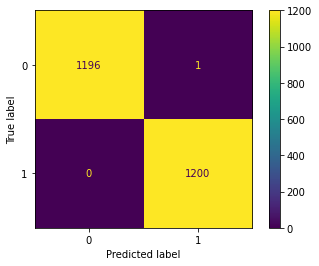

In [59]:
# Trainset
evaluate(X_train, Y_train, xgb, "Trainset")

Testset Accuracy:  0.9892996108949417


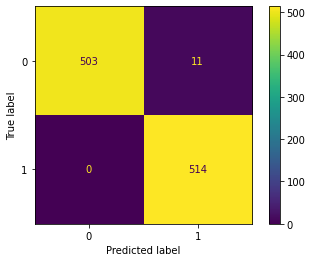

In [60]:
# Testset
evaluate(X_test, Y_test, xgb, "Testset")

### Hyperparameter Tuning 

In [61]:
xgb = GradientBoostingClassifier(random_state=seed)

In [62]:
grid_params ={
            'max_depth':[5,10,20,30,40,50,60,70],
            'min_samples_split':[5,10,20,25,30,40,50]
            }

In [64]:
grid = GridSearchCV(xgb, grid_params)
grid.fit(X_train, Y_train)
print(grid.best_params_)

{'max_depth': 5, 'min_samples_split': 50}


### Tuned Model

In [65]:
xgb = GradientBoostingClassifier(min_samples_split = grid.best_params_["min_samples_split"],
                                  max_depth = grid.best_params_["max_depth"],
                                  random_state = seed)
xgb.fit(X_train, Y_train)

GradientBoostingClassifier(max_depth=5, min_samples_split=50, random_state=100)

Testset Accuracy:  0.9922178988326849


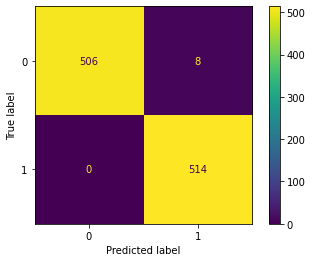

In [66]:
# Testset
evaluate(X_test, Y_test, xgb, "Testset")
# Accuracy improves slightly

In [67]:
importances = pd.DataFrame(data={
    'Variable': X_train.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances
# According to XGBoost, age is the most important variable, then loan, then income

,Variable,Importance
1,age,0.586852
2,loan,0.288258
0,income,0.124890


# Neural Network (Keras)

Assumptions:
1. Independent variables are scaled and have the same order of magnitude
2. For logistic activation functions, the threshold for P(Y=1) is 0.5
3. Batching in neural network assumes homogenous data

### Base model 

In [68]:
# Train-test split, using the scaled values
X_train, X_test, Y_train, Y_test  = train_test_split(X_scaled,Y,test_size=0.3,stratify=Y,random_state=seed)

In [69]:
nn = Sequential()

In [70]:
# Define neural network layers
nn.add(Dense(10, input_dim=3, activation='relu')) 
# relu is faster than sigmoid/logistic activation function (linear vs. exponential), 
# also avoids vanishing gradient situation where the bigger the input (in absolute value) the smaller the gradient of the sigmoid function.
nn.add(Dropout(0.2)) # To prevent overfitting

In [71]:
# Hidden layers
nn.add(Dense(4, activation="relu"))
nn.add(Dropout(0.3))

In [72]:
# Output layer
nn.add(Dense(1, activation='sigmoid'))

In [73]:
nn.compile(loss = 'binary_crossentropy', optimizer="Adamax", metrics = ['accuracy'])
# binary cross entropy since discrete for 2 classes 
# Optimizer is to specify the manner in which the weights are updated (learning rate)

In [74]:
nn.fit(X_train, Y_train, batch_size=10, epochs=10)

Epoch 1/10
240/240 [==============================] - 1s 3ms/step - loss: 0.5457 - accuracy: 0.8002
Epoch 2/10
240/240 [==============================] - 1s 3ms/step - loss: 0.4682 - accuracy: 0.8394
Epoch 3/10
240/240 [==============================] - 1s 2ms/step - loss: 0.3988 - accuracy: 0.8607
Epoch 4/10
240/240 [==============================] - 0s 2ms/step - loss: 0.3594 - accuracy: 0.8569
Epoch 5/10
240/240 [==============================] - 0s 2ms/step - loss: 0.3216 - accuracy: 0.8715
Epoch 6/10
240/240 [==============================] - 0s 2ms/step - loss: 0.3036 - accuracy: 0.8757
Epoch 7/10
240/240 [==============================] - 0s 1ms/step - loss: 0.2924 - accuracy: 0.8707
Epoch 8/10
240/240 [==============================] - 0s 2ms/step - loss: 0.2791 - accuracy: 0.8769
Epoch 9/10
240/240 [==============================] - 0s 2ms/step - loss: 0.2759 - accuracy: 0.8790
Epoch 10/10
240/240 [==============================] - 0s 2ms/step - loss: 0.2605 - accuracy: 0.8807

In [75]:
# Trainset
nn.evaluate(X_train, Y_train)
# Testset
nn.evaluate(X_test, Y_test)

33/33 [==============================] - 0s 1ms/step - loss: 0.1488 - accuracy: 0.9562


[0.14881747961044312, 0.9562256932258606]

In [76]:
prednn=nn.predict(X_train)
prednn=np.where(prednn>0.5,1,0)
cm=confusion_matrix(Y_train, prednn)
print(cm)
accuracy=(cm[0,0]+cm[1,1])/sum(sum(cm))
print("Trainset Accuracy:",accuracy)

[[1084  113]
 [  20 1180]]
Trainset Accuracy: 0.9445139758030872


In [77]:
prednn=nn.predict(X_test)
prednn=np.where(prednn>0.5,1,0)
cm=confusion_matrix(Y_test, prednn)
print(cm)
accuracy=(cm[0,0]+cm[1,1])/sum(sum(cm))
print("Testset Accuracy:",accuracy)

[[472  42]
 [  3 511]]
Testset Accuracy: 0.9562256809338522


In [78]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [79]:
#nn.weights

### Hyperparameter Tuning and Tuned Model

In [80]:
grid_params ={
            'batch_size': [10, 20, 40, 60, 80, 100],
            'epochs': [10, 20, 50, 100]
            }

In [81]:
def build_nn(): 
    nn=Sequential()

    nn.add(Dense(10, input_dim=3, activation="relu"))
    nn.add(Dropout(0.2))
    
    nn.add(Dense(8, activation="relu"))
    nn.add(Dropout(0.3))
    
    nn.add(Dense(1, activation="sigmoid"))
 
    nn.compile(loss = 'binary_crossentropy', optimizer = 'Adamax', metrics = ['accuracy'])

    return nn

In [82]:
nn = KerasClassifier(build_fn=build_nn, verbose=2)

<ipython-input-82-fbf06dd9e082>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=build_nn, verbose=2)


In [83]:
grid = GridSearchCV(estimator=nn, param_grid=grid_params, n_jobs = -1)
grid.fit(X_train, Y_train)


Epoch 1/100
240/240 - 1s - loss: 0.5950 - accuracy: 0.7076 - 1s/epoch - 4ms/step
Epoch 2/100
240/240 - 0s - loss: 0.4885 - accuracy: 0.8456 - 278ms/epoch - 1ms/step
Epoch 3/100
240/240 - 0s - loss: 0.3981 - accuracy: 0.8707 - 343ms/epoch - 1ms/step
Epoch 4/100
240/240 - 0s - loss: 0.3390 - accuracy: 0.8828 - 470ms/epoch - 2ms/step
Epoch 5/100
240/240 - 0s - loss: 0.2960 - accuracy: 0.9049 - 317ms/epoch - 1ms/step
Epoch 6/100
240/240 - 0s - loss: 0.2723 - accuracy: 0.9120 - 308ms/epoch - 1ms/step
Epoch 7/100
240/240 - 0s - loss: 0.2470 - accuracy: 0.9224 - 366ms/epoch - 2ms/step
Epoch 8/100
240/240 - 0s - loss: 0.2278 - accuracy: 0.9212 - 356ms/epoch - 1ms/step
Epoch 9/100
240/240 - 0s - loss: 0.2090 - accuracy: 0.9282 - 280ms/epoch - 1ms/step
Epoch 10/100
240/240 - 0s - loss: 0.2064 - accuracy: 0.9307 - 265ms/epoch - 1ms/step
Epoch 11/100
240/240 - 0s - loss: 0.1911 - accuracy: 0.9366 - 285ms/epoch - 1ms/step
Epoch 12/100
240/240 - 0s - loss: 0.1845 - accuracy: 0.9383 - 396ms/epoch - 2

Epoch 98/100
240/240 - 0s - loss: 0.0544 - accuracy: 0.9862 - 307ms/epoch - 1ms/step
Epoch 99/100
240/240 - 0s - loss: 0.0567 - accuracy: 0.9812 - 272ms/epoch - 1ms/step
Epoch 100/100
240/240 - 0s - loss: 0.0604 - accuracy: 0.9829 - 307ms/epoch - 1ms/step


GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002CEDB946550>,
             n_jobs=-1,
             param_grid={'batch_size': [10, 20, 40, 60, 80, 100],
                         'epochs': [10, 20, 50, 100]})

In [84]:
print(grid.best_params_)

{'batch_size': 10, 'epochs': 100}


In [86]:
pred=grid.predict(X_test)
pred=np.where(pred > 0.5, 1, 0)
cm=confusion_matrix(Y_test, pred)
print(cm)

[[507   7]
 [  1 513]]


In [87]:
accuracy=(cm[0,0]+cm[1,1])/sum(sum(cm))
print("Testset Accuracy:", accuracy)

Testset Accuracy: 0.9922178988326849


# Neural Network (MLP)

### Base Model

In [88]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(6,2), random_state=seed)

In [89]:
mlp.fit(X_train, Y_train)

MLPClassifier(hidden_layer_sizes=(6, 2), random_state=100, solver='lbfgs')

Trainset Accuracy:  1.0


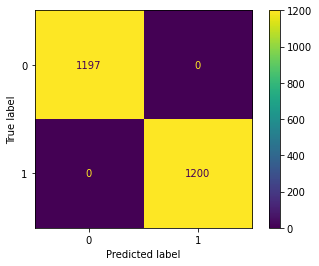

In [90]:
# Trainset
evaluate(X_train, Y_train, mlp, "Trainset")

Trainset Accuracy:  0.9990272373540856


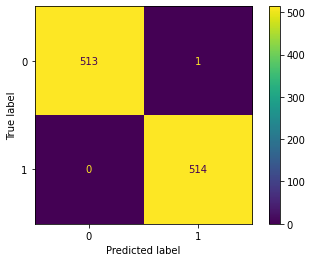

In [91]:
# Testset
evaluate(X_test, Y_test, mlp, "Trainset")

### Hyperparameter Tuning

In [92]:
grid_params ={
            "solver": ["lbfgs", "sgd", "adam"]
            }

In [93]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(6,2), random_state=seed)

In [94]:
grid = GridSearchCV(mlp, grid_params)
grid.fit(X_train, Y_train)

C:\Users\jacks\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jacks\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jacks\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jacks\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jacks\anaconda3\lib\site-packages\sklearn\neural_network\_multi

GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(6, 2),
                                     random_state=100, solver='lbfgs'),
             param_grid={'solver': ['lbfgs', 'sgd', 'adam']})

In [95]:
print(grid.best_params_)
# Same as solver used in base model, hence the tuned model will be the same as the base model

{'solver': 'lbfgs'}


In [98]:
joblib.dump(logreg, "Logreg")

['Logreg']

In [99]:
joblib.dump(cart, "CART")

['CART']

In [100]:
joblib.dump(rf, "RF")

['RF']

In [101]:
joblib.dump(xgb,"XGB")

['XGB']

In [102]:
joblib.dump(nn, "NN")

['NN']

In [103]:
joblib.dump(mlp, "MLP")

['MLP']